# MiDaSv3 Depth Estimation


In [1]:
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import center_of_mass
import torch

## Setup

In [73]:
test_images = glob('assets/*.jpg')
test_images

['assets/cyber.jpg']

In [78]:
image = plt.imread(test_images[0])

In [ ]:
# downloading the Midas model from TorchHub.
#model_type = "DPT_Large"     # MiDaS v3 - Large (1.28GM) (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid (470M) (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small (82M) (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)

# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [ ]:
# Use transforms to resize and normalize the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

## Create Depth Map

In [79]:
imgbatch = transform(image).to(device)

# Making a prediction
with torch.no_grad():
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

output = prediction.cpu().numpy()

# normalizing the output predictions for cv2 to read.
output_norm = cv.normalize(output, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# colored depth map
output_norm_c = (output_norm*255).astype(np.uint8)
output_norm_c = cv.applyColorMap(output_norm_c, cv.COLORMAP_MAGMA)

Text(0.5, 1.0, 'Depth Map')

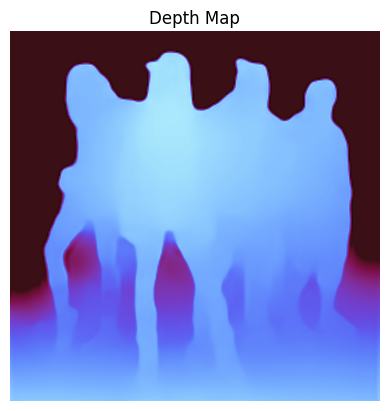

In [80]:
plt.imshow(output_norm_c, cmap=plt.cm.binary)
plt.axis(False)
plt.title('Depth Map')

In [81]:
print('Max depth: ', output_norm.max(), ', Min depth: ', output_norm.min(), ', Mean depth: ', output_norm.mean())

Max depth:  0.99999994 , Min depth:  -1.1621175e-09 , Mean depth:  0.6086985


## Get Depth of Center Point

In [82]:
center_y, center_x = center_of_mass(output_norm)
center_y, center_x

(725.2488075505419, 655.4564076983983)

In [83]:
# arrays from normed depth map
h , w = output_norm.shape
x_grid = np.arange(w)
y_grid = np.arange(h)

In [84]:
# create a spline object using the output_norm arrays
spline = RectBivariateSpline(y_grid, x_grid, output_norm)

In [85]:
#Define depth to distance
def depth_to_distance(depth_value,depth_scale):
    return 1.0 / (depth_value*depth_scale)

In [86]:
#Passing the x and y co-ordinates distance function to calculate distance.
#Tweak with the depth scale to see what suits you!
depth_scale = 1
depth_mid_filt = spline(center_x, center_y)
depth_midas = depth_to_distance(depth_mid_filt, depth_scale)

(-0.5, 1279.5, 1279.5, -0.5)

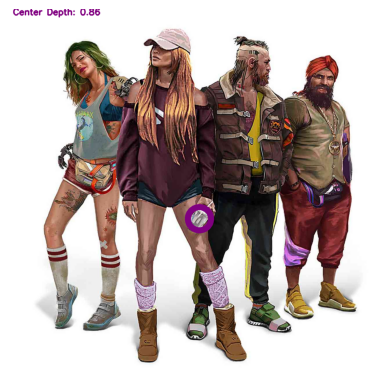

In [90]:
cv.putText(image, 'Center Depth: ' + str(np.format_float_positional(depth_mid_filt, precision=2)),(10,20),cv.FONT_HERSHEY_SIMPLEX,1,(128,0,128),4)
cv.circle(image,(int(center_x), int(center_y)), 40, (128,0,128), 20)
plt.imshow(image, cmap=plt.cm.binary)
plt.axis(False)